# Sophie

In [1]:
import pandas as pd
import numpy as np

# other
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
from time import time
from google.colab import drive
import os

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn-muted', 'dark_background'])
%matplotlib inline

# processing & model selection
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# models
try:
    %tensorflow_version 2.x
except Exception:
    pass
  
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.layers import Dense, Flatten, Input, Concatenate, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

tf.random.set_seed(410)
np.random.seed(410)

TensorFlow 2.x selected.
2.1.0-rc1


# 1. Preprocessing

Due to the complex nature of our dataset, where some of its attributes are temporal and some are not, our model will consist of two separate inputs to account for this. 

In [2]:
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
df = pd.read_pickle('drive/My Drive/Python/Fut/sofa_dataset.pkl')
df.head(2)

,player_name,overall,club,league,nationality,position,height,weight,intl_rep,pace,pace_acceleration,pace_sprint_speed,dribbling,drib_agility,drib_balance,drib_reactions,drib_ball_control,drib_dribbling,drib_composure,shooting,shoot_positioning,shoot_finishing,shoot_shot_power,shoot_long_shots,shoot_volleys,shoot_penalties,passing,pass_vision,pass_crossing,pass_free_kick,pass_short,pass_long,pass_curve,defending,def_interceptions,def_heading,def_marking,def_stand_tackle,def_slid_tackle,physicality,phys_jumping,phys_stamina,phys_strength,phys_aggression,pref_foot,att_workrate,def_workrate,weak_foot,skill_moves,resource_id,date,price,game,days,weekday,promo,source,days_release,relative_price
0,Iniesta,87,other,other,top,CM,171,68,4,69.0,70,68,90.0,79,84,88,94,90,89,70.0,84,70,65,71,74,71,87.0,94,77,70,92,86,80,61.0,66,54,67,57,56,57.0,47,55,58,58,Right,High,Med,4,4,41,2018-09-21,7807,FIFA 19,2,4,0,packs,0.002740,111.00526091283947
1,Iniesta,87,other,other,top,CM,171,68,4,69.0,70,68,90.0,79,84,88,94,90,89,70.0,84,70,65,71,74,71,87.0,94,77,70,92,86,80,61.0,66,54,67,57,56,57.0,47,55,58,58,Right,High,Med,4,4,41,2018-09-22,8714,FIFA 19,3,5,0,packs,0.005479,111.61777891635711


In [4]:
df_train = df[df.game=='FIFA 19']
df_val = df[df.game=='FIFA 20']

print("""{} datapoints in Training Set
{} datapoints in Validation Set"""\
.format(df_train.shape[0], df_val.shape[0]))

133741 datapoints in Training Set
37075 datapoints in Validation Set


In [ ]:
drop_cols = ['player_name', 'resource_id', 'date', 'game', 'relative_price']
temp_cols = ['promo', 'weekday', 'days', 'days_release', 'price']
attr_cols = [c for c in df.columns if c not in (drop_cols + temp_cols)]
target = 'price'

### Temporal Transformation

In [ ]:
df_train_temp = df_train.groupby(['resource_id', 'date'])[temp_cols].first().reset_index(1)
df_val_temp = df_val.groupby(['resource_id', 'date'])[temp_cols].first().reset_index(1)

In [8]:
df_train_temp.head(2)

,date,promo,weekday,days,days_release,price
resource_id,,,,,,
41,2018-09-21,0,4,2,0.002740,7807
41,2018-09-22,0,5,3,0.005479,8714


In [ ]:
# temporal variable scaling
temp_num = ['weekday', 'days']
temp_scaler = MinMaxScaler().fit(df_train_temp[temp_num].values)

df_train_temp[temp_num] = temp_scaler.transform(df_train_temp[temp_num].values)
df_val_temp[temp_num] = temp_scaler.transform(df_val_temp[temp_num].values)

# price scaling
price_scaler = MinMaxScaler().fit(df_train_temp.price.values.reshape(-1,1))
df_train_temp['price'] = price_scaler.transform(df_train_temp.price.values.reshape(-1,1))
df_val_temp['price'] = price_scaler.transform(df_val_temp.price.values.reshape(-1,1))

In [10]:
df_train_temp.head(3)

,date,promo,weekday,days,days_release,price
resource_id,,,,,,
41,2018-09-21,0,0.666667,0.007752,0.002740,0.007332
41,2018-09-22,0,0.833333,0.011628,0.005479,0.008251
41,2018-09-23,0,1.000000,0.015504,0.008219,0.008757


In [ ]:
assert df_train_temp.shape[1] == df_val_temp.shape[1]

### Attributes Transformation

In [ ]:
df_train_attr = df_train.groupby('resource_id')[attr_cols].first()
df_val_attr = df_val.groupby('resource_id')[attr_cols].first()

In [ ]:
attr_cat = ['club', 'league', 'nationality', 'pref_foot', 'att_workrate', 'def_workrate', 'position', 'source']
attr_num = [v for v in df_train_attr.columns if v not in attr_cat]
num_mask = df_train_attr.columns.isin(attr_num)

ct = make_column_transformer((MinMaxScaler(), num_mask), (OneHotEncoder(), ~num_mask))
attr_ct = ct.fit(df_train_attr)

def attr_transform(df):
    resources = df.index.values
    cols = attr_num + attr_ct.named_transformers_['onehotencoder'].get_feature_names().tolist()
    data = attr_ct.transform(df)
    
    return pd.DataFrame(data=data, columns=cols, index=resources)

df_train_attr = attr_transform(df_train_attr)
df_val_attr = attr_transform(df_val_attr)

In [15]:
df_train_attr.head(3)

,overall,height,weight,intl_rep,pace,pace_acceleration,pace_sprint_speed,dribbling,drib_agility,drib_balance,drib_reactions,drib_ball_control,drib_dribbling,drib_composure,shooting,shoot_positioning,shoot_finishing,shoot_shot_power,shoot_long_shots,shoot_volleys,shoot_penalties,passing,pass_vision,pass_crossing,pass_free_kick,pass_short,pass_long,pass_curve,defending,def_interceptions,def_heading,def_marking,def_stand_tackle,def_slid_tackle,physicality,phys_jumping,phys_stamina,phys_strength,phys_aggression,weak_foot,skill_moves,x0_other,x0_top,x1_other,x1_top,x2_other,x2_top,x3_CAM,x3_CB,x3_CDM,x3_CF,x3_CM,x3_LB,x3_LF,x3_LM,x3_LW,x3_LWB,x3_RB,x3_RM,x3_RW,x3_RWB,x3_ST,x4_Left,x4_Right,x5_High,x5_Low,x5_Med,x6_High,x6_Low,x6_Med,x7_packs
41,0.250000,0.228571,0.238095,0.75,0.464286,0.508475,0.446429,0.833333,0.696970,0.772727,0.694444,0.883721,0.842105,0.714286,0.658228,0.805195,0.674157,0.423729,0.678161,0.705882,0.626667,0.818182,0.935065,0.694444,0.674157,0.833333,0.803279,0.753247,0.506849,0.602410,0.338235,0.640449,0.505882,0.505747,0.155556,0.246377,0.043478,0.338710,0.453333,0.666667,0.666667,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
9014,0.083333,0.485714,0.523810,0.75,0.642857,0.728814,0.589286,0.791667,0.818182,0.863636,0.611111,0.744186,0.824561,0.600000,0.848101,0.805195,0.842697,0.779661,0.850575,0.847059,0.720000,0.709091,0.792208,0.736111,0.797753,0.595238,0.557377,0.883117,0.109589,0.253012,0.294118,0.224719,0.141176,0.160920,0.266667,0.434783,0.239130,0.483871,0.306667,0.000000,0.666667,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
20775,0.000000,0.342857,0.214286,0.50,0.714286,0.745763,0.696429,0.791667,0.878788,0.772727,0.416667,0.744186,0.824561,0.457143,0.708861,0.727273,0.640449,0.661017,0.781609,0.776471,0.666667,0.727273,0.805195,0.902778,0.707865,0.523810,0.622951,0.935065,0.000000,0.096386,0.147059,0.213483,0.035294,0.011494,0.266667,0.478261,0.260870,0.290323,0.666667,0.666667,1.000000,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


In [ ]:
assert df_train_attr.shape[1] == df_val_attr.shape[1]

### Input Processing

In [ ]:
def data_process(df_temp, df_attr, num_obs, num_steps):
    """
    Constructs the temporal and attribute datasets for our model
    Arguments:
        - df_temp: our temporal dataframe
        - df_attr: our attributes dataframe
        - num_obs: number of observations to be used in model
        - num_steps: number of steps ahead to predict
    Returns:
        - temp_data: temporal dataset
        - attr_data: attribute dataset
        - targ_data: target dataset
        - reso_data: corresponding resource
    """
    
    resources = df_temp.index.unique().values
    
    reso_data = []
    targ_data = []
    temp_data = []
    attr_data = []
    
    for r in resources:
        
        attributes = df_attr[df_attr.index==r].values[0]
        temporal_d = df_temp[df_temp.index==r].values
        
        total_obs = temporal_d.shape[0]
        window_size = num_obs + num_steps
        
        if window_size > total_obs:
            continue
        
        for i in range(total_obs - window_size):
            
            attr = np.append(attributes, temporal_d[i+num_obs-1][-1])
            temp = temporal_d[i:i+num_obs][:, 1:]
            targ = temporal_d[i+num_obs:i+num_obs+num_steps][:, -1]
            targ_data.append(targ)
            temp_data.append(temp)
            attr_data.append(attr)
            reso_data.append(r)
          
    return np.asarray(attr_data), np.asarray(temp_data), np.asarray(targ_data), np.asarray(reso_data)

In [ ]:
# Number of past observations to look at
NUM_OBS = 7
# Number of future observations to use as target
NUM_STEPS = 3

train_attr, train_temp, train_targ, train_res = data_process(df_train_temp, df_train_attr, NUM_OBS, NUM_STEPS)
val_attr, val_temp, val_targ, val_res = data_process(df_val_temp, df_val_attr, NUM_OBS, NUM_STEPS)

In [ ]:
assert train_res.shape[0] == train_temp.shape[0]
assert train_temp.shape[0] == train_targ.shape[0]
assert train_targ.shape[0] == train_attr.shape[0]

# 2. Modeling
The temporal data will be fed into an LSTM layer, the attributes will be fed into a Dense layer; their outputs will be concatenated and fed into more layers. 

In [ ]:
train_temp = train_temp.astype(np.float64)
val_temp = val_temp.astype(np.float64)

train_targ = train_targ.astype(np.float64)
val_targ = val_targ.astype(np.float64)

In [22]:
print('Temporal shape:', train_temp[0].shape)
print('Attributes shape:', train_attr[0].shape)
print('Target shape:', train_targ[0].shape)

Temporal shape: (7, 5)
Attributes shape: (72,)
Target shape: (3,)


In [ ]:
np.random.seed(42)
np.random.shuffle(train_attr)
np.random.seed(42)
np.random.shuffle(train_temp)
np.random.seed(42)
np.random.shuffle(train_targ)

In [ ]:
tf.random.set_seed(42)

input_attr = Input(shape=train_attr[0].shape)
input_temp = Input(shape=train_temp[0].shape)

# temporal path
X_temp1 = GRU(128, activation='relu', recurrent_activation='relu',
              dropout=0.1, recurrent_dropout=0.1, 
              return_sequences=True)(input_temp)
X_temp2 = GRU(128, activation='relu', recurrent_activation='relu',
              dropout=0.1, recurrent_dropout=0.1,
              return_sequences=True)(X_temp1)
X_temp3 = GRU(128, activation='relu', recurrent_activation='relu',
              dropout=0.1, recurrent_dropout=0.1,
              return_sequences=True)(X_temp2)
X_temp4 = GRU(128, activation='relu', recurrent_activation='relu')(X_temp3)

# attribute path
X_attr1 = Dense(256, activation='relu')(input_attr)
X_attr2 = Dense(256, activation='relu')(X_attr1)
X_attr3 = Dense(256, activation='relu')(X_attr2)
X_attr4 = Dense(128, activation='relu')(X_attr3)

# merged path
X = Concatenate(axis=1)([X_attr4, X_temp4])
X = Dense(256, activation='relu')(X)
X = Dense(128, activation='relu')(X)
output = Dense(NUM_STEPS, activation='relu')(X)

model = Model([input_attr, input_temp], output)

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 72)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 7, 5)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          18688       input_1[0][0]                    
__________________________________________________________________________________________________
gru (GRU)                       (None, 7, 128)       51840       input_2[0][0]                    
______________________________________________________________________________________________

In [26]:
checkpoint_folder = '/content/drive/My Drive/Python/Fut/checkpoints'

if not os.path.exists(checkpoint_folder):
    os.makedirs(checkpoint_folder)

checkpoint_path = os.path.join(checkpoint_folder, 'weights.{epoch:02d}-{val_loss:.2f}.hdf5')

try:
    latest = os.path.join(checkpoint_folder, os.listdir(checkpoint_folder)[-1])
    model.load_weights(latest)
    print('Checkpoint loaded.')

except:
    print('No checkpoints in the folder.')

Checkpoint loaded.


In [27]:
optimizer = Adam()
model.compile(optimizer=optimizer, loss='mse')

callbacks_list = [EarlyStopping(monitor='val_loss', patience=4),
                  ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss',
                                  save_best_only=True)]

history = model.fit([train_attr, train_temp], train_targ,
                    validation_data=([val_attr, val_temp], val_targ),
                    callbacks=callbacks_list,
                    batch_size=32, epochs=30) 

Train on 124965 samples, validate on 32301 samples
Epoch 1/30
124965/124965 [==============================] - 264s 2ms/sample - loss: 1.5054e-04 - val_loss: 1.2198e-04
Epoch 2/30
124965/124965 [==============================] - 256s 2ms/sample - loss: 3.3521 - val_loss: 1.7212e-04
Epoch 3/30
124965/124965 [==============================] - 256s 2ms/sample - loss: 1.5629e-04 - val_loss: 1.2230e-04
Epoch 4/30
124965/124965 [==============================] - 256s 2ms/sample - loss: 1.2992e-04 - val_loss: 1.0230e-04
Epoch 5/30
124965/124965 [==============================] - 255s 2ms/sample - loss: 1.3697e-04 - val_loss: 1.0308e-04
Epoch 6/30
124965/124965 [==============================] - 255s 2ms/sample - loss: 1.3286e-04 - val_loss: 1.1699e-04
Epoch 7/30
124965/124965 [==============================] - 254s 2ms/sample - loss: 1.3508e-04 - val_loss: 299484.0344
Epoch 8/30
124965/124965 [==============================] - 254s 2ms/sample - loss: 1.2939e-04 - val_loss: 9.9484e-05
Epoch 9/

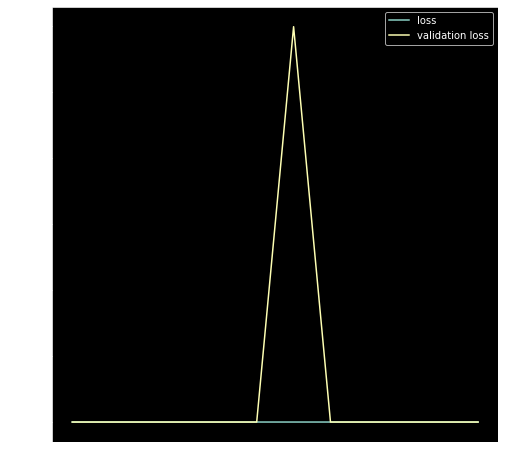

In [28]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='validation loss')
ax.legend()
plt.show()

In [ ]:
val_preds = model.predict([val_attr, val_temp])

In [30]:
print('Example Target')
example_targ = price_scaler.inverse_transform(val_targ[0]\
                                              .reshape(1, -1))
print(example_targ)
print()


print('Example Prediction')
example_pred = price_scaler.inverse_transform(val_preds[0]\
                                              .reshape(1, -1))
print(example_pred)

Example Target
[[5780. 5771. 5654.]]

Example Prediction
[[8971.797 9501.31  9426.875]]


# Model Evaluation

Other than the loss metric used above, we can also plot some of the predictions as to get an idea of the model's performance.

In [ ]:
def plot_preds(i):
    """
    plot the predictions for ith obs in the test set
    """
    colors = sns.color_palette()

    # find player's resource id and their data
    player_res = val_res[i]
    player_data = df_val[df_val.resource_id == player_res]
    player_name = player_data.player_name.values[0]
    player_name = df_val[df_val.resource_id == player_res].player_name.values[0]

    # find their past prices, predictions and true target
    i_prices = price_scaler.inverse_transform(val_temp[i][:, -1].reshape(1, -1))
    i_preds = price_scaler.inverse_transform(val_preds[i].reshape(1, -1))[0]
    i_target = price_scaler.inverse_transform(val_targ[i].reshape(1, -1))
    true_prices = np.concatenate([i_prices, i_target], axis=1)[0]
    num_prices = len(true_prices)

    # find the corresponding x-axis labels
    first_d = val_temp[i][:, -2][0] * 365
    x_idx = np.arange(0, num_prices, 1) + first_d
    x_idx_scaled = x_idx / 365
    player_dates = player_data[player_data.days_release.isin(x_idx_scaled)].date.values
    # first_date = player_dates[0].astype(datetime)
    # first_date = pd.to_datetime(first_date)
    first_date = player_dates[0]
    first_date = np.datetime64(first_date)
    dates = [first_date + np.timedelta64(i, 'D') for i in range(num_prices)]

    num_preds = len(i_preds)
    pred_idx = dates[-num_preds:]

    # create the plot
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    ax.plot(dates, true_prices, label='True', color=colors[0])
    ax.plot(pred_idx, i_preds, label='Prediction', color=colors[1])
    ax.tick_params(axis='x', rotation=90)
    ax.set_title(player_name)
    ax.set_xlabel('Date')
    ax.legend()

    return i_preds, i_target

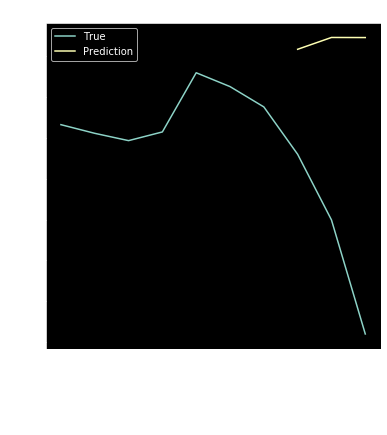

In [45]:
i = np.random.choice(len(val_res))
i_preds, i_target = plot_preds(i)

In [ ]:
model.save('drive/My Drive/Python/Fut/models/model_7_3.h5')